# Series prediction

## Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


## Data

In [ ]:
import csv
time_step = []
sunspots = []

#data=pd.read_csv('daily-minimum-temperatures-in-me.csv',sep=',',encoding='utf8',error_bad_lines=False) 
data=pd.read_csv('daily-minimum-temperatures-in-me.csv', sep=',',encoding="utf8",names=['Date','temperature']) 
time=data.index[0:3650]
df = pd.DataFrame(data)
series=np.array(df['temperature'][1:], dtype=float)
print(np.shape(series))

(3650,)


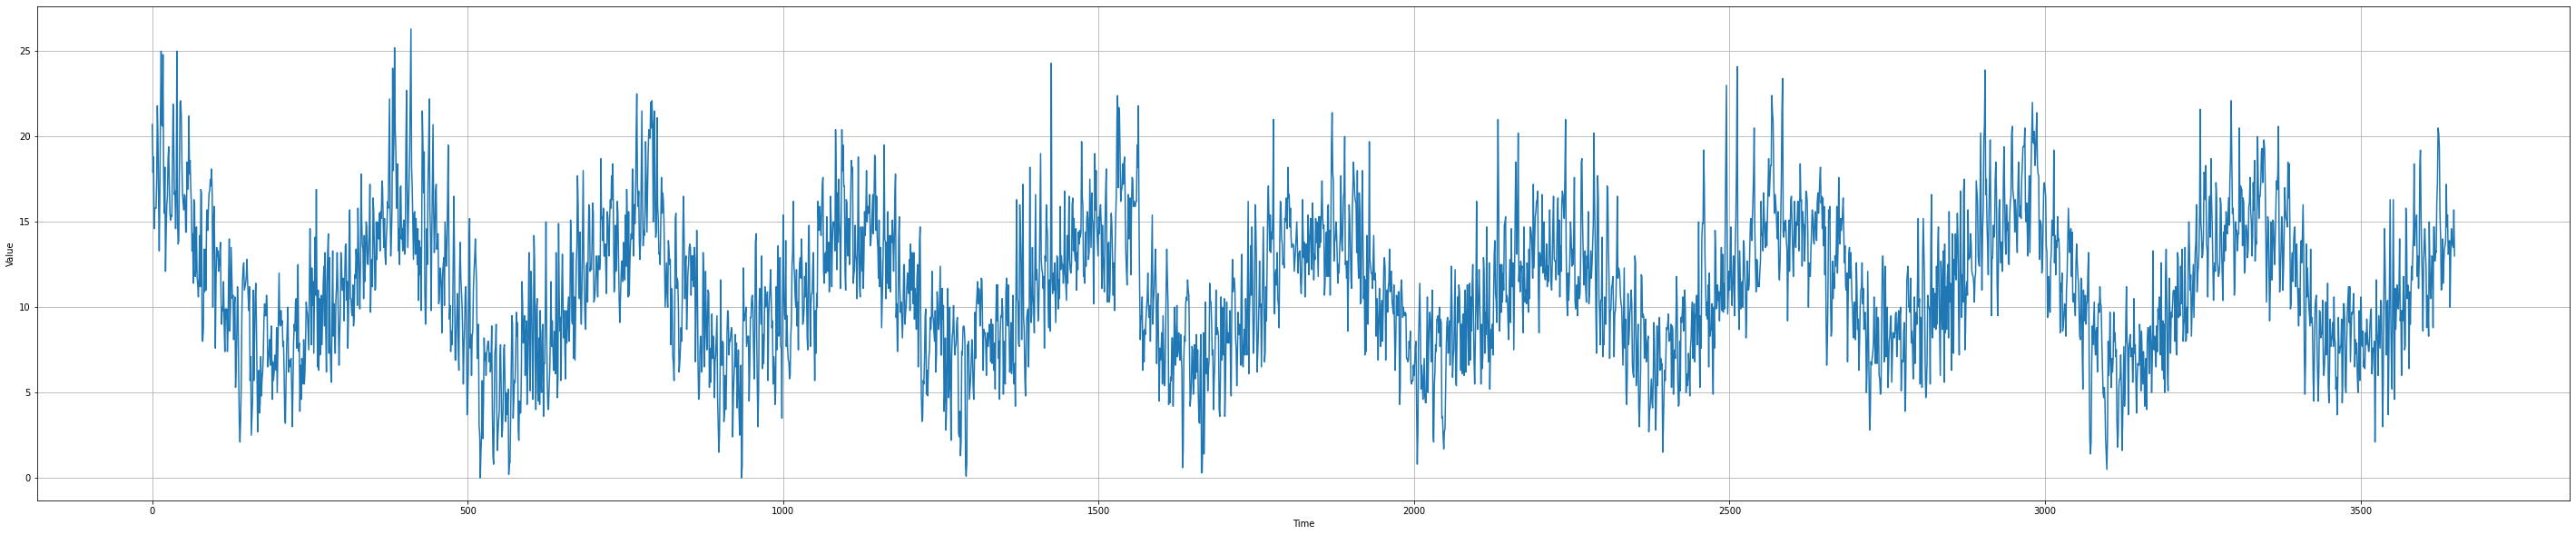

In [ ]:
plt.figure(figsize=(50,10))

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
plot_series(time, series)

## Train and validation sets

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=50, batch_size=100, shuffle_buffer=1500)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


## Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 25)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)


Epoch 1/200
30/30 [==============================] - 7s 98ms/step - loss: 4.8199 - mae: 5.2996
Epoch 2/200
30/30 [==============================] - 3s 99ms/step - loss: 2.8119 - mae: 3.2757
Epoch 3/200
30/30 [==============================] - 3s 98ms/step - loss: 2.1753 - mae: 2.6291
Epoch 4/200
30/30 [==============================] - 3s 97ms/step - loss: 2.0629 - mae: 2.5171
Epoch 5/200
30/30 [==============================] - 3s 103ms/step - loss: 2.0091 - mae: 2.4628
Epoch 6/200
30/30 [==============================] - 3s 97ms/step - loss: 1.9926 - mae: 2.4463
Epoch 7/200
30/30 [==============================] - 3s 99ms/step - loss: 1.9552 - mae: 2.4083
Epoch 8/200
30/30 [==============================] - 3s 97ms/step - loss: 1.9233 - mae: 2.3758
Epoch 9/200
30/30 [==============================] - 3s 98ms/step - loss: 1.9062 - mae: 2.3586
Epoch 10/200
30/30 [==============================] - 3s 97ms/step - loss: 1.8881 - mae: 2.3406
Epoch 11/200
30/30 [============================

## Prediction

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(100).prefetch(1)
    forecast = model.predict(ds)
    return forecast

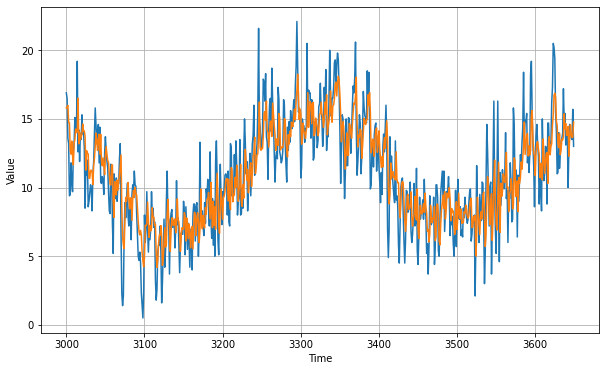

In [ ]:
window_size=50
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)